In [1]:
import os
import logging
import glob

from dotenv import load_dotenv
from sqlalchemy import create_engine
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import webdataset as wds
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import seaborn as sns

import net.preprocessing as preprocessing
import net.net as net
import net.io as io
import gfs.fetch
import utils

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
pd.set_option('display.max_columns', None)
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

In [4]:
load_dotenv()

connection_string = "postgresql://{user}:{password}@{host}:{port}/{db}".format(
    user=os.getenv('DB_USER'),
    password=os.getenv('DB_PASSWORD'),
    host=os.getenv('DB_HOST'),
    port=os.getenv('DB_PORT'),
    db=os.getenv('DB_NAME')
)
engine = create_engine(connection_string)

In [5]:
def create_dataloaders(train_path, val_path, batch_size=32, num_workers=4):
    """
    Create train and validation DataLoaders from WebDataset files.
    
    Args:
        train_path (str): Path to training data directory containing .tar files
        val_path (str): Path to validation data directory containing .tar files
        batch_size (int): Batch size for DataLoaders
        num_workers (int): Number of worker processes for data loading
        
    Returns:
        tuple: (train_loader, val_loader)
    """
    # Define pipeline for both datasets
    def create_pipeline(path):
        # Create dataset from .tar files with correct shard formatting
        shards = glob.glob(f"{path}/*.tar")  # Get list of all .tar files in path
        dataset = (
            wds.WebDataset(shards)  # Use explicit shard pattern
            .shuffle(1000)  # Shuffle with a buffer of 1000 samples
            .decode()  # Decode the compressed data
            .to_tuple("features.pth", "targets.pth", "date.pth")  # Extract the tensors we want
        )
        
        # Create DataLoader
        loader = wds.WebLoader(
            dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            persistent_workers=True,
            shuffle=False,  # WebDataset handles shuffling internally
        )
        
        # Make the loader reusable
        loader.length = float('inf')  # Allow multiple epochs
        
        return loader
    
    # Create train and validation loaders
    train_loader = create_pipeline(train_path)
    val_loader = create_pipeline(val_path)
    
    return train_loader, val_loader

In [9]:
train_loader, val_loader = create_dataloaders(
    train_path="training/train_data_old",
    val_path="training/val_data_old",
    batch_size=512,
    num_workers=2
)

In [10]:
model = io.load_net("training/models/champion.pth") #model_300_mono_10_reg_0

In [11]:
def score_dataset(model, loader):
    model.eval()
    all_predictions = []
    all_targets = []
    all_dates = []
    all_site_ids = []
    
    with torch.no_grad():
        for features, targets, dates in tqdm(loader, desc="Scoring"):
            # Get predictions
            outputs = model(features)
            
            # Collect predictions, targets, dates, and site_ids
            all_predictions.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
            all_dates.append(dates.cpu().numpy())
            all_site_ids.append(features['site_id'].cpu().numpy())
    
    # Concatenate all batches
    predictions = np.concatenate(all_predictions)
    targets = np.concatenate(all_targets)
    dates = np.concatenate(all_dates)
    site_ids = np.concatenate(all_site_ids)
    
    # Create predictions DataFrame
    pred_df = pd.DataFrame(predictions, columns=[f'pred_XC{i}' for i in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]])
    pred_df['site_id'] = site_ids
    pred_df['date'] = pd.to_datetime(dates, unit='s')
    
    # Create targets DataFrame
    target_df = pd.DataFrame(targets, columns=[f'target_XC{i}' for i in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]])
    target_df['site_id'] = site_ids
    target_df['date'] = pd.to_datetime(dates, unit='s')
    
    return pred_df, target_df

# Score the validation dataset
pred_df, target_df = score_dataset(model, val_loader)

Scoring: 0it [00:00, ?it/s]/mnt/c/Users/janhe/OneDrive/Plocha/repos/glideator/analytics/env-jl/lib/python3.10/site-packages/webdataset/autodecode.py:121: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to th

In [12]:
targets = [f'XC{threshold}' for threshold in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]]

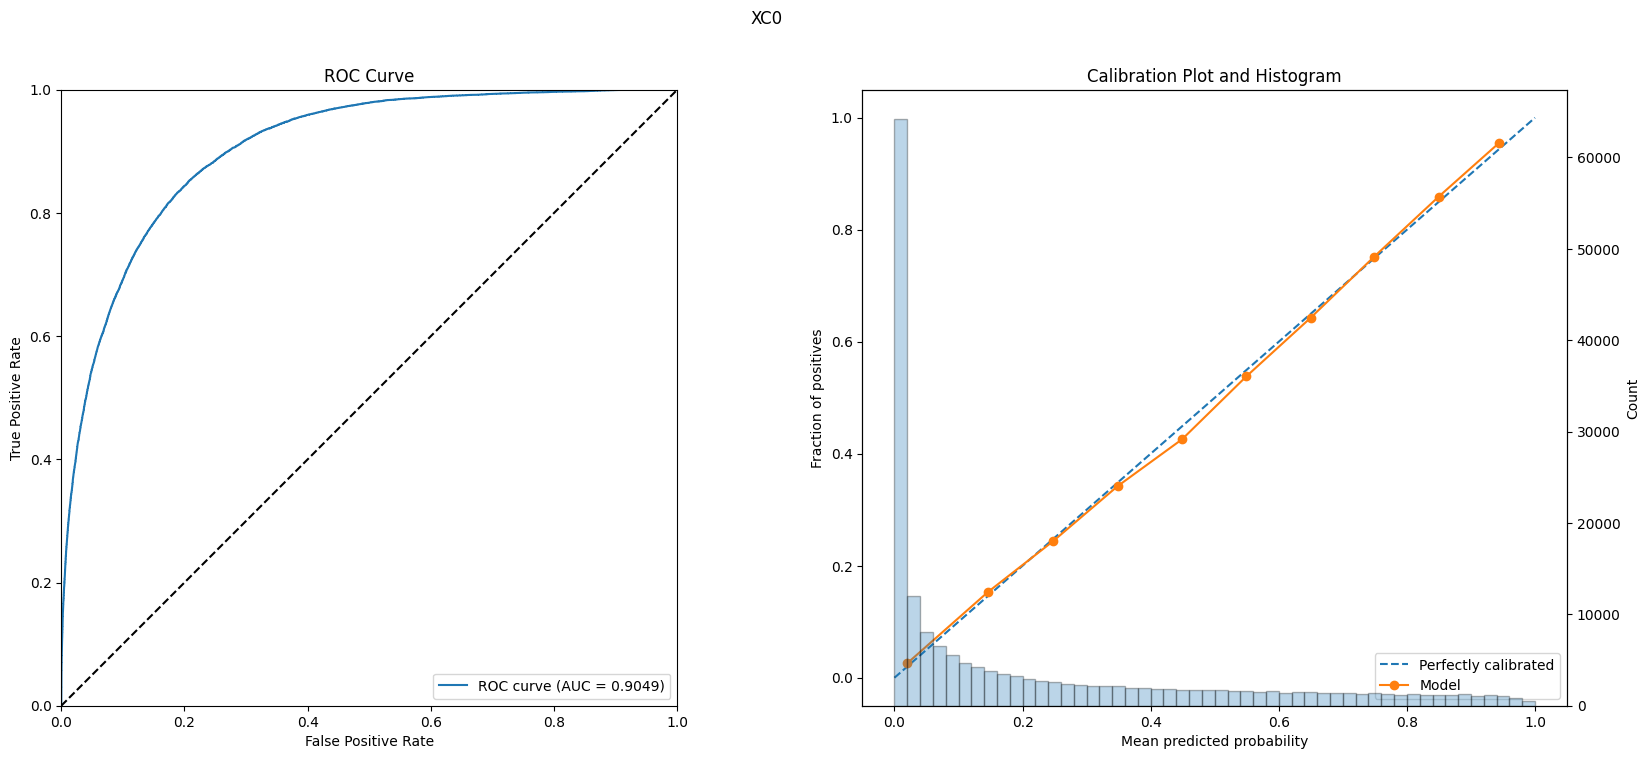

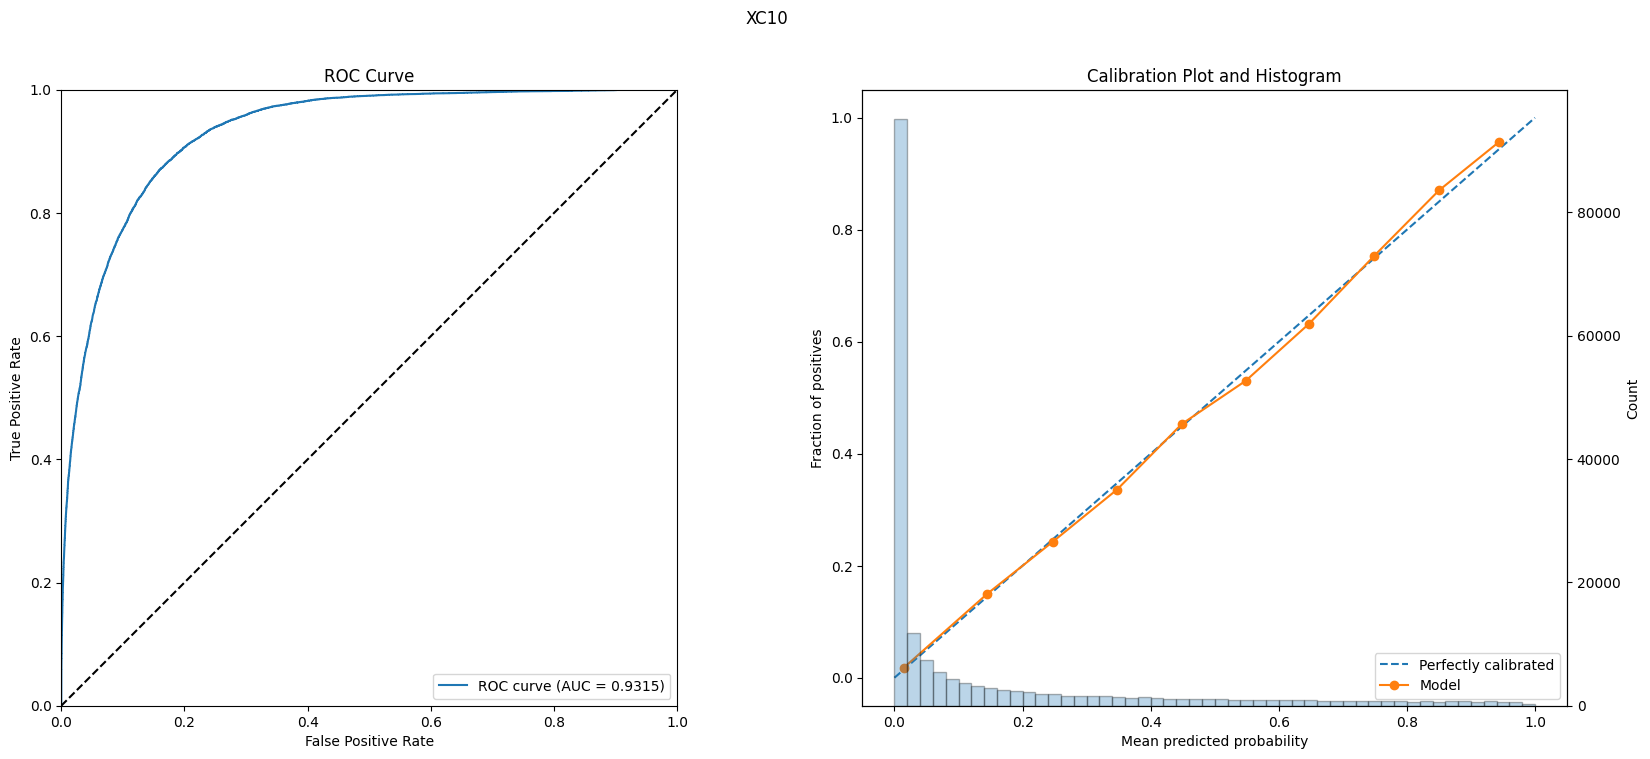

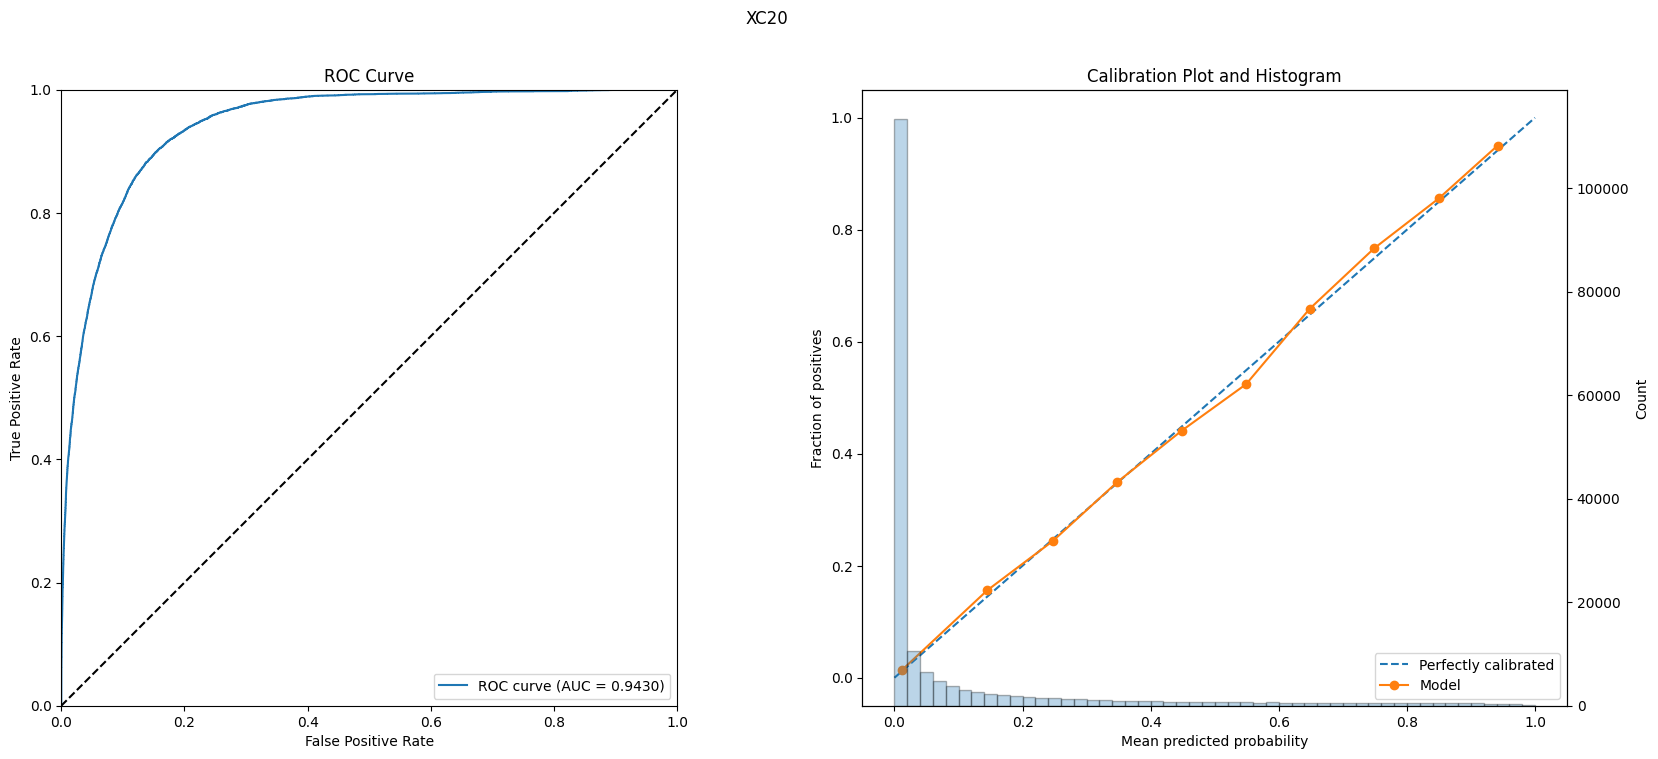

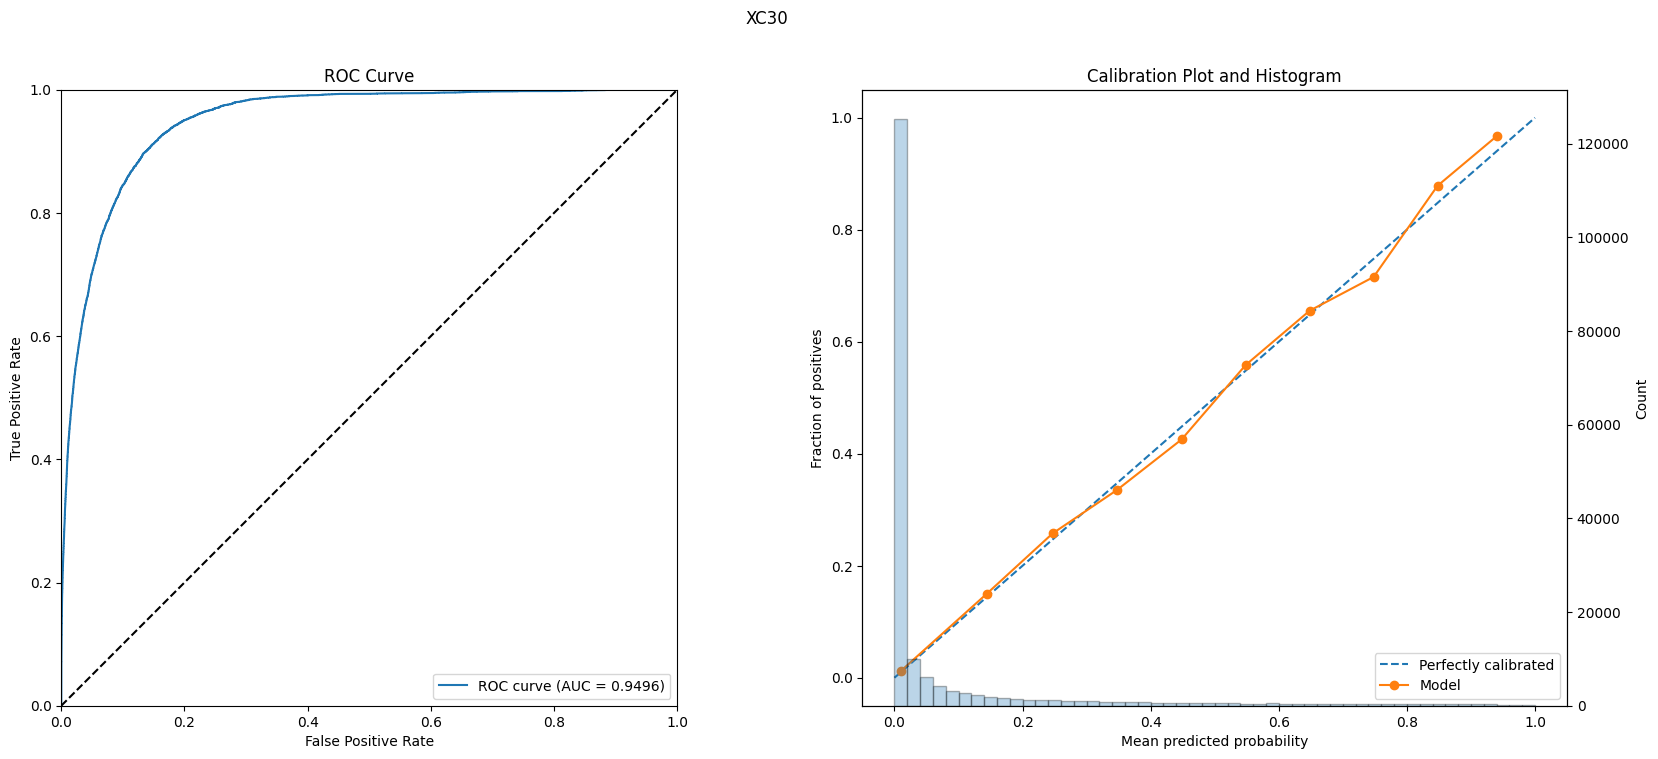

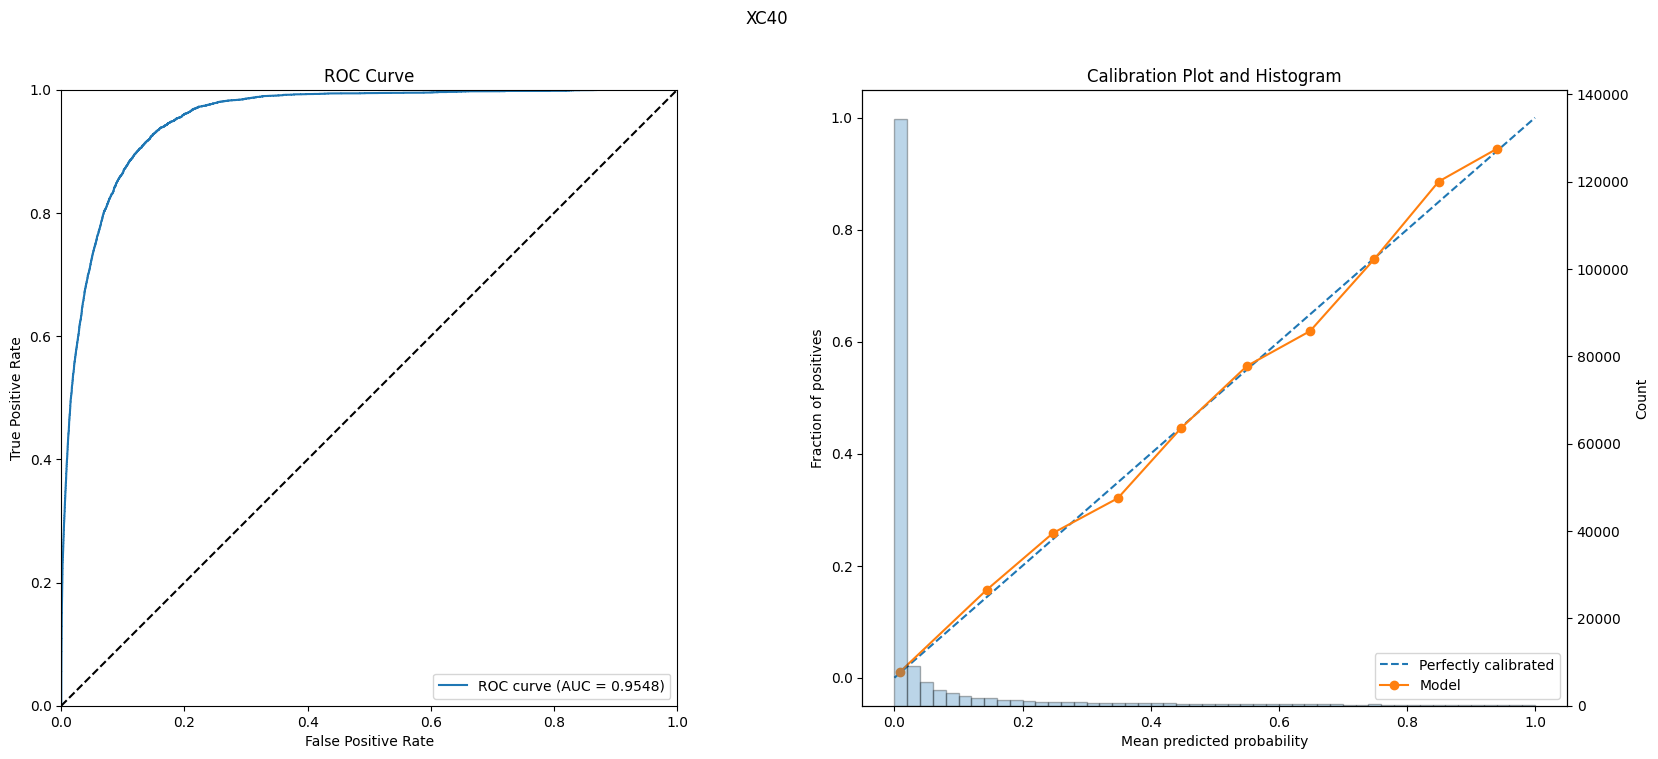

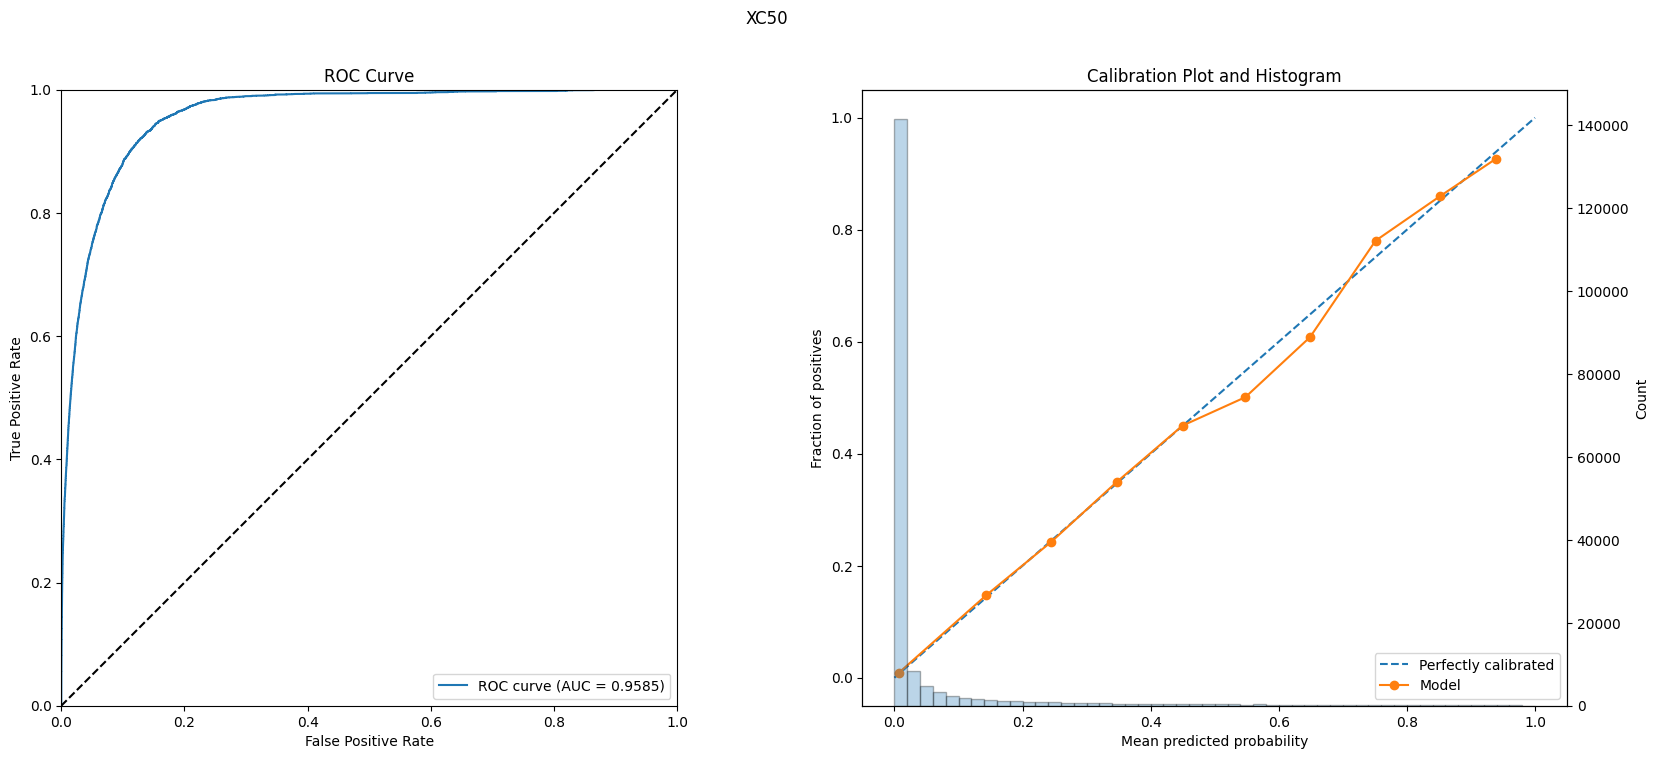

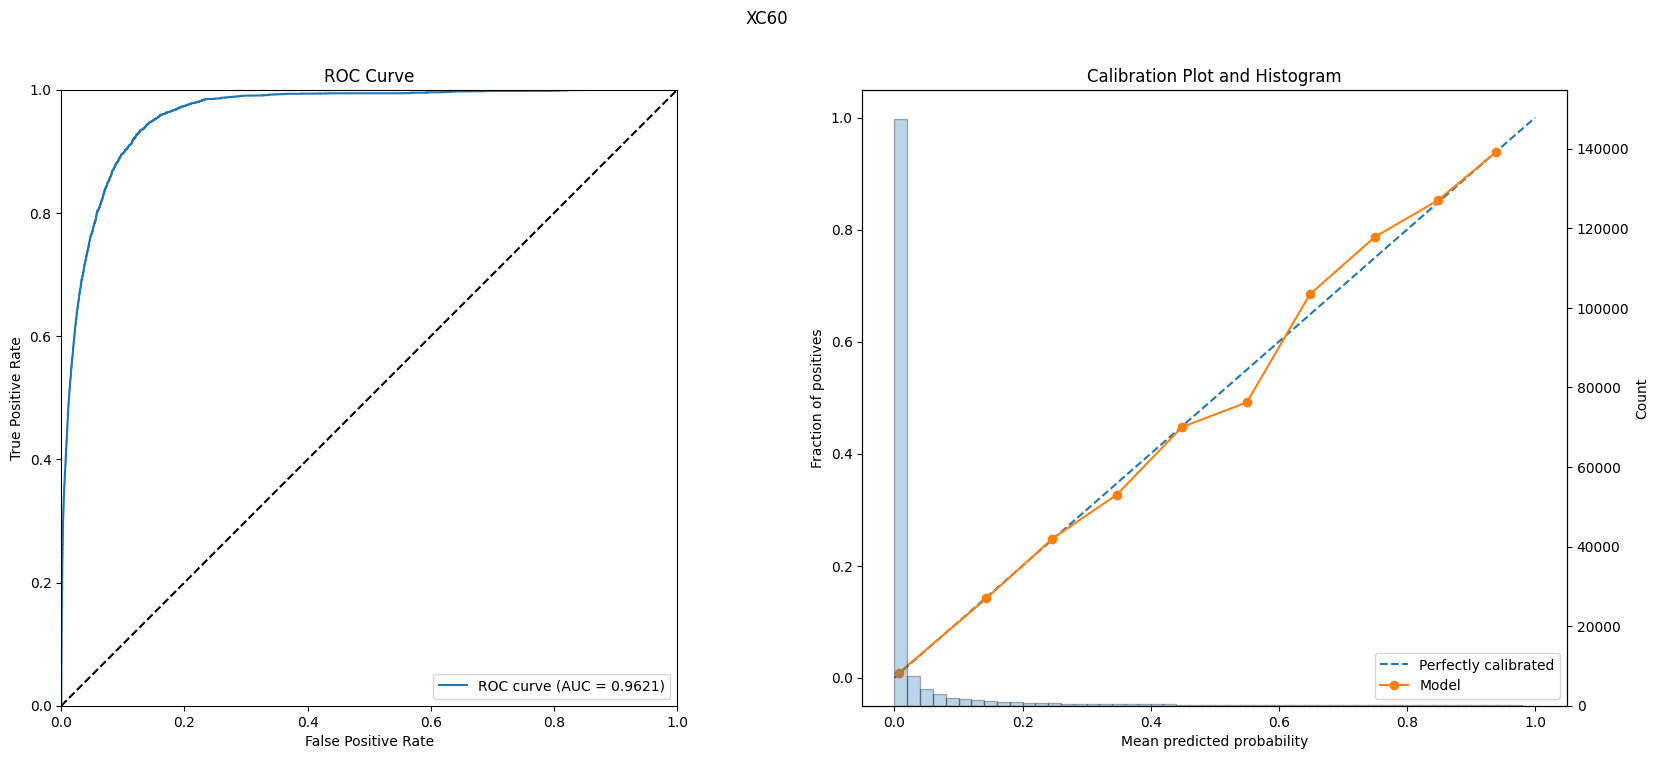

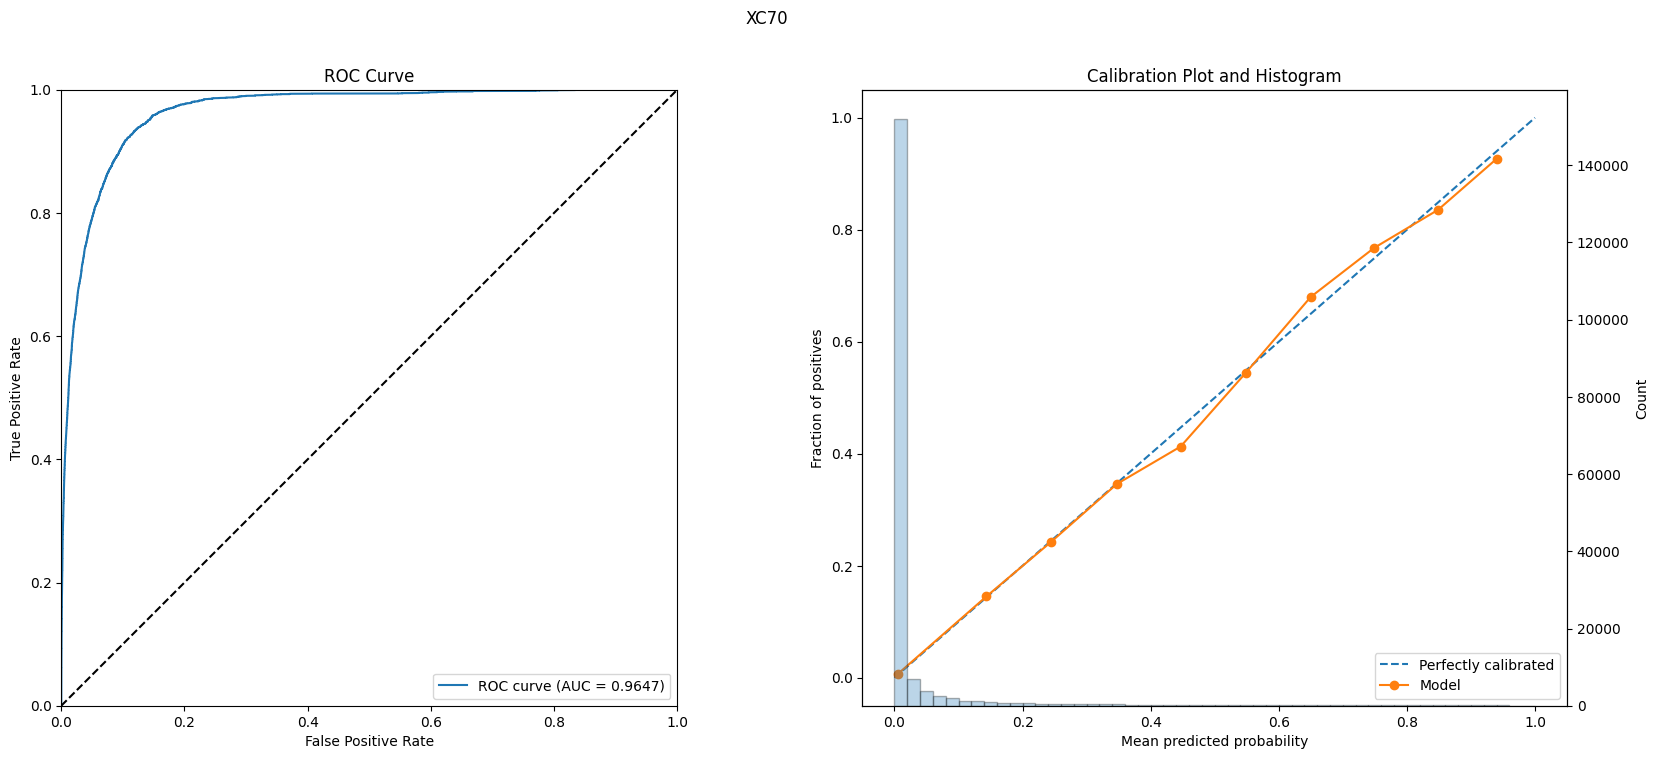

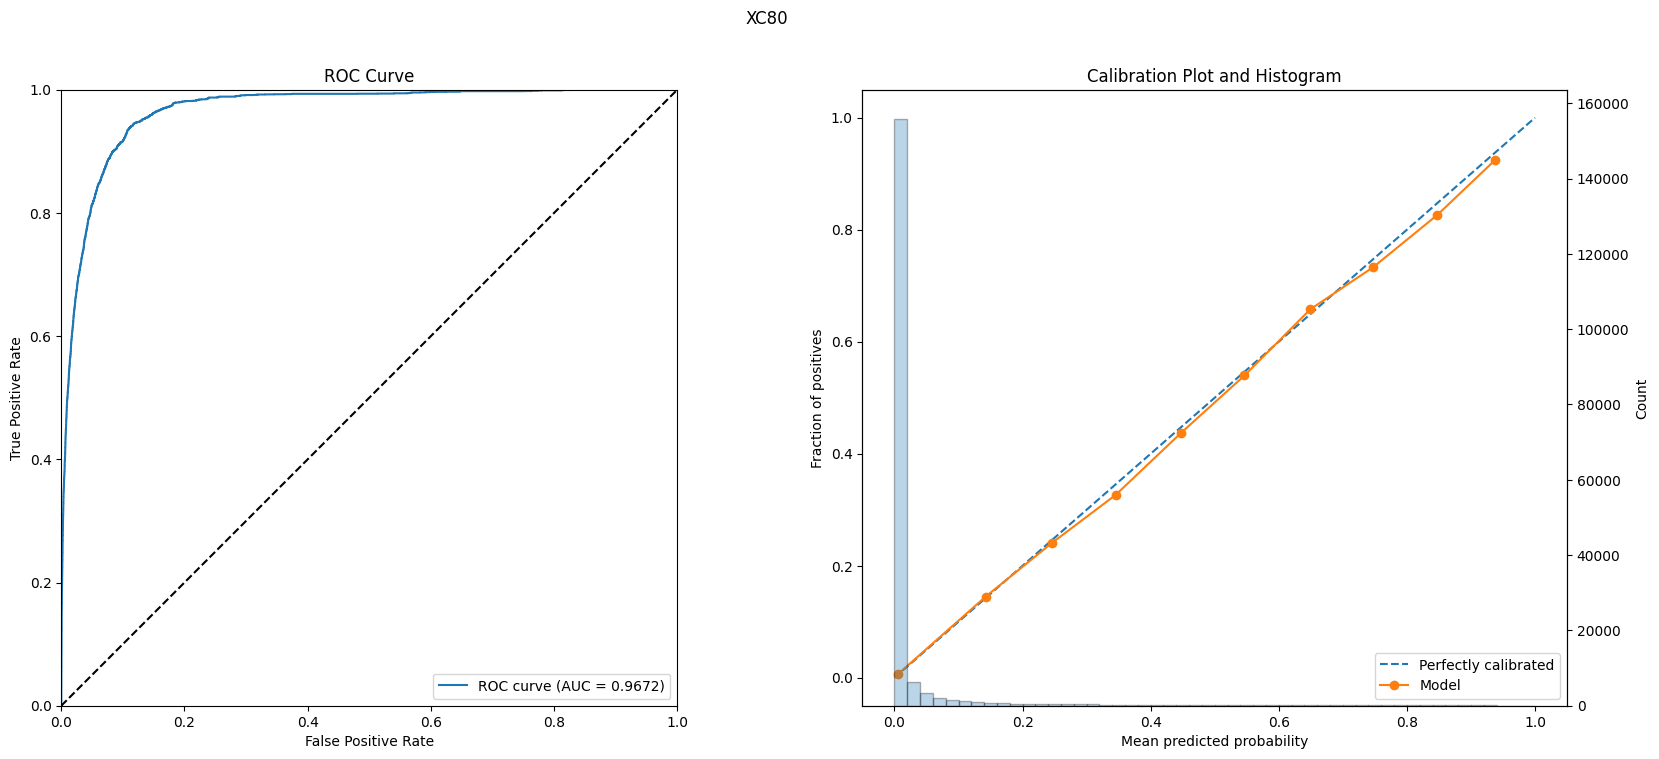

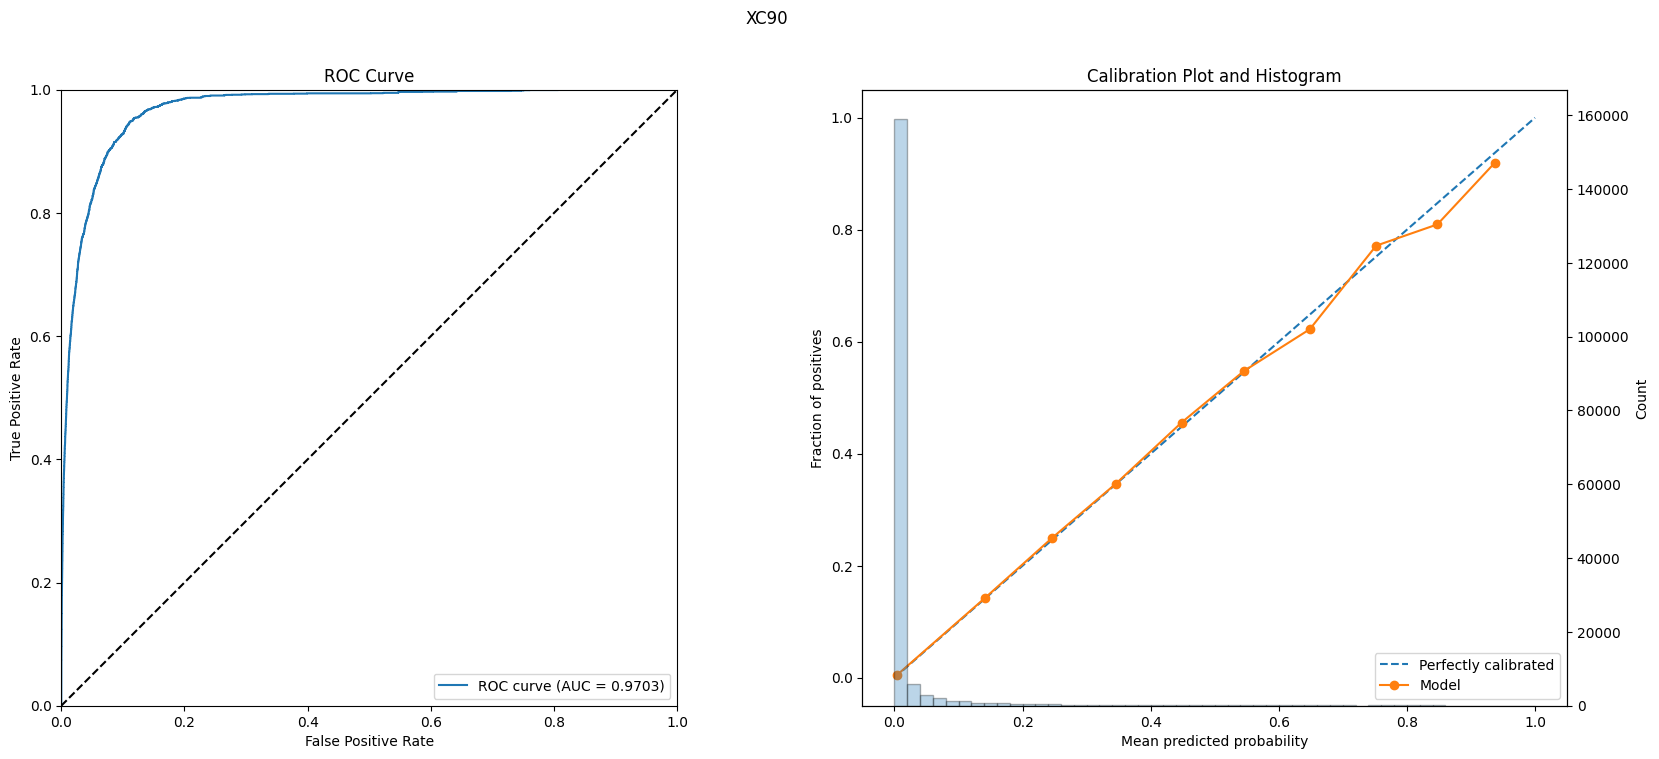

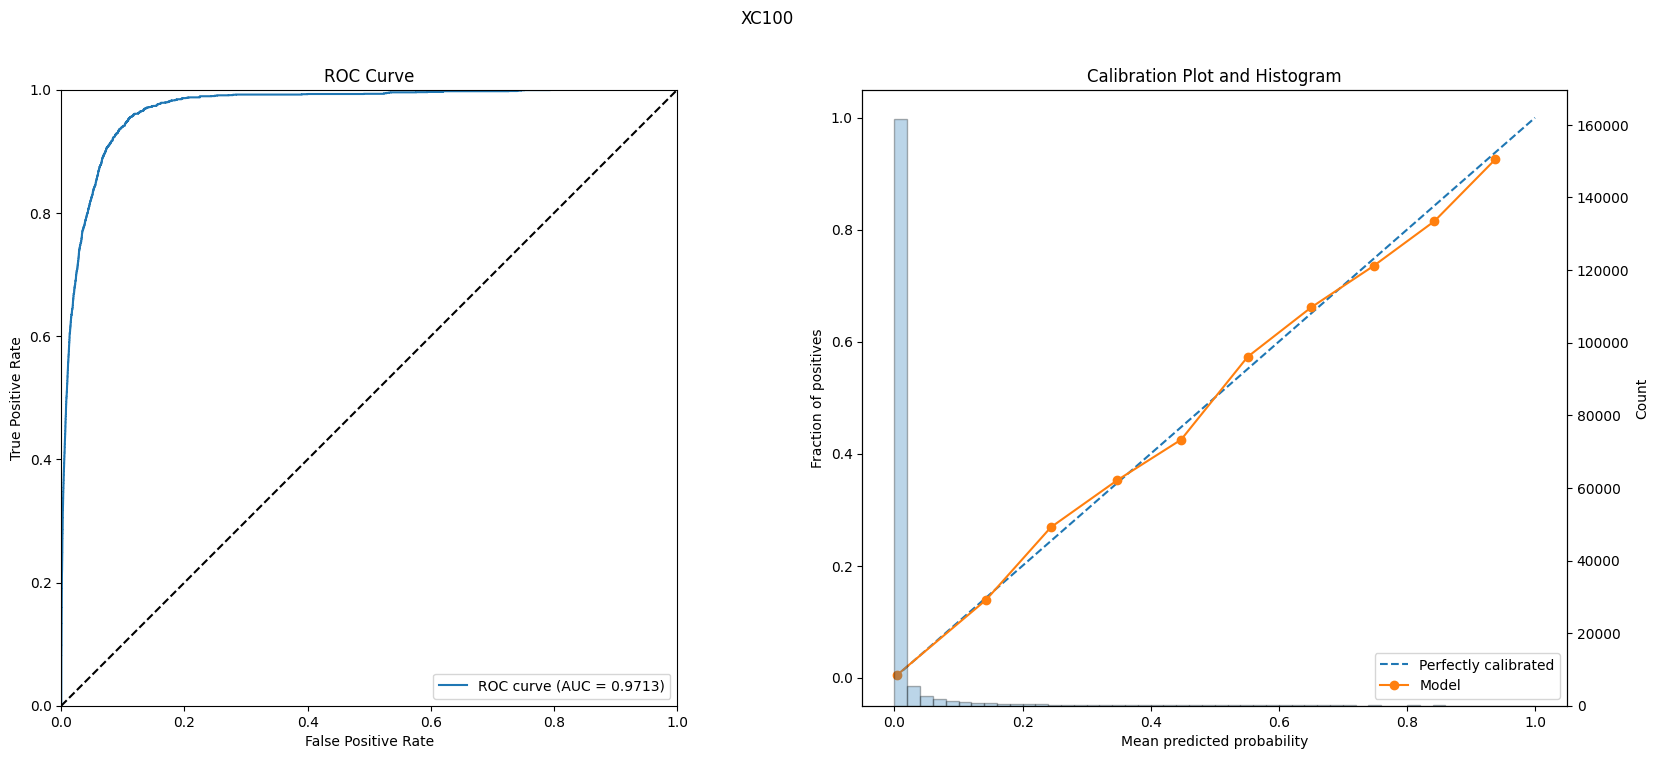

In [13]:
for target in targets:
    y_pred_proba = np.array(pred_df[f'pred_{target}'])
    y_val_launch = np.array(target_df[f'target_{target}'])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        
    utils.plot_roc_curve(y_val_launch, y_pred_proba, ax=ax1)
    ax1.set_title(f'ROC Curve')

    utils.plot_calibration_and_histogram(y_val_launch, y_pred_proba, ax=ax2)
    ax2.set_title(f'Calibration Plot and Histogram')
    plt.suptitle(target)
    plt.show()

In [14]:
# # Get unique site_ids
# site_ids = sorted(pred_df['site_id'].unique())

# target = 'XC0'
# for site_id in site_ids:
#     # Filter validation data for the current site
#     site_mask = pred_df['site_id'] == site_id
#     y_val_launch = target_df.loc[site_mask, f'target_{target}']
#     y_pred_proba_launch = pred_df.loc[site_mask, f'pred_{target}']
    
#     try:
#         # Create a figure with two subplots side by side
#         fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
#         # Plot ROC curve on the first subplot
#         utils.plot_roc_curve(y_val_launch, y_pred_proba_launch, ax=ax1)
#         ax1.set_title(f'Site {site_id} - ROC Curve')
    
#         # Plot calibration curve and histogram on the second subplot
#         utils.plot_calibration_and_histogram(y_val_launch, y_pred_proba_launch, ax=ax2)
#         ax2.set_title(f'Site {site_id} - Calibration Plot and Histogram')
        
#         # Set the main title for the figure
#         fig.suptitle(f'Performance Metrics for Site ID: {site_id}', fontsize=16)
    
#         # Adjust layout and display the figure
#         plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#         plt.show()
#     except Exception as e:
#         print(f"Error processing site {site_id}: {e}")

In [15]:
def compute_metrics_by_site(pred_df, target_df):
    from sklearn.metrics import roc_auc_score, brier_score_loss
    import pandas as pd
    import numpy as np
    
    # Get the unique site ids
    site_ids = pred_df['site_id'].unique()
    
    # List to store results
    results = []
    
    # XC thresholds
    thresholds = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    
    # For each site_id
    for site_id in site_ids:
        # Filter data for this site
        site_preds = pred_df[pred_df['site_id'] == site_id]
        site_targets = target_df[target_df['site_id'] == site_id]
        
        # For each XC threshold
        for threshold in thresholds:
            pred_col = f'pred_XC{threshold}'
            target_col = f'target_XC{threshold}'
            
            # Get the predictions and targets
            y_pred = site_preds[pred_col].values
            y_true = site_targets[target_col].values
            
            # Skip if all targets are the same class (ROC AUC is undefined)
            if len(np.unique(y_true)) < 2:
                roc_auc = np.nan
            else:
                try:
                    roc_auc = roc_auc_score(y_true, y_pred)
                except:
                    roc_auc = np.nan
            
            # Calculate Brier score
            brier = brier_score_loss(y_true, y_pred)
            
            # Add to results
            results.append({
                'site_id': site_id,
                'threshold': threshold,
                'roc_auc': roc_auc,
                'brier_score': brier,
                'n_samples': len(y_true)
            })
    
    # Convert to DataFrame
    metrics_df = pd.DataFrame(results)
    
    # Add average metrics across all sites using the full sample
    for threshold in thresholds:
        # Filter data for the current threshold across all sites
        all_sites_preds = pred_df[f'pred_XC{threshold}'].values
        all_sites_targets = target_df[f'target_XC{threshold}'].values
        
        # Calculate ROC AUC and Brier score for all sites
        if len(np.unique(all_sites_targets)) < 2:
            all_sites_roc_auc = np.nan
        else:
            try:
                all_sites_roc_auc = roc_auc_score(all_sites_targets, all_sites_preds)
            except:
                all_sites_roc_auc = np.nan
        
        all_sites_brier = brier_score_loss(all_sites_targets, all_sites_preds)
        
        # Add row for average metrics
        metrics_df = pd.concat([metrics_df, pd.DataFrame([{
            'site_id': 'All Sites',
            'threshold': threshold,
            'roc_auc': all_sites_roc_auc,
            'brier_score': all_sites_brier,
            'n_samples': len(all_sites_targets)
        }])], ignore_index=True)
    
    return metrics_df

# Compute metrics using the existing pred_df and target_df
metrics_df = compute_metrics_by_site(pred_df, target_df)

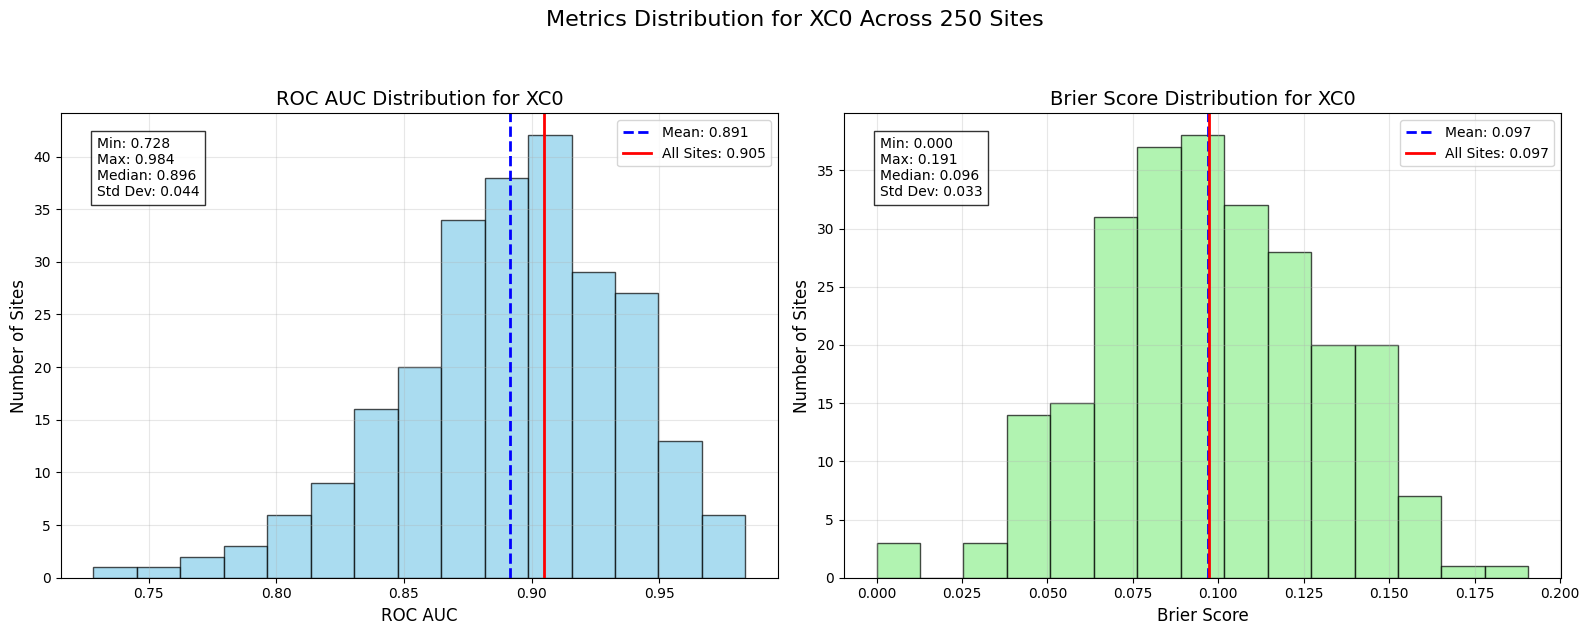

Note: 3 sites were excluded from the ROC AUC histogram (likely single-class sites)


In [16]:
def plot_metrics_histograms(metrics_df, threshold):
    """
    Plot histograms of ROC AUC and Brier Score for a specific threshold with two reference lines:
    1. Mean metric (excluding NaNs)
    2. All sites value from input dataframe
    
    Args:
        metrics_df: DataFrame with metrics by site_id and threshold
        threshold: XC threshold value to plot (e.g., 0, 10, 20, etc.)
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Filter data for the specified threshold and exclude the "All Sites" aggregate row
    df_threshold = metrics_df[(metrics_df['threshold'] == threshold) & 
                             (metrics_df['site_id'] != 'All Sites')]
    
    # Get the "All Sites" values for reference lines
    all_sites_row = metrics_df[(metrics_df['threshold'] == threshold) & 
                              (metrics_df['site_id'] == 'All Sites')]
    
    if not all_sites_row.empty:
        all_sites_roc_auc = all_sites_row['roc_auc'].values[0]
        all_sites_brier = all_sites_row['brier_score'].values[0]
    else:
        all_sites_roc_auc = None
        all_sites_brier = None
    
    # Calculate mean metrics (properly handling NaNs)
    mean_roc_auc = df_threshold['roc_auc'].mean(skipna=True)
    mean_brier = df_threshold['brier_score'].mean(skipna=True)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot ROC AUC histogram
    ax1.hist(df_threshold['roc_auc'].dropna(), bins=15, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.axvline(x=mean_roc_auc, color='blue', linestyle='--', linewidth=2, 
                label=f'Mean: {mean_roc_auc:.3f}')
    
    if all_sites_roc_auc is not None:
        ax1.axvline(x=all_sites_roc_auc, color='red', linestyle='-', linewidth=2, 
                    label=f'All Sites: {all_sites_roc_auc:.3f}')
    
    ax1.set_title(f'ROC AUC Distribution for XC{threshold}', fontsize=14)
    ax1.set_xlabel('ROC AUC', fontsize=12)
    ax1.set_ylabel('Number of Sites', fontsize=12)
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Plot Brier Score histogram
    ax2.hist(df_threshold['brier_score'].dropna(), bins=15, alpha=0.7, color='lightgreen', edgecolor='black')
    ax2.axvline(x=mean_brier, color='blue', linestyle='--', linewidth=2,
                label=f'Mean: {mean_brier:.3f}')
    
    if all_sites_brier is not None:
        ax2.axvline(x=all_sites_brier, color='red', linestyle='-', linewidth=2,
                    label=f'All Sites: {all_sites_brier:.3f}')
    
    ax2.set_title(f'Brier Score Distribution for XC{threshold}', fontsize=14)
    ax2.set_xlabel('Brier Score', fontsize=12)
    ax2.set_ylabel('Number of Sites', fontsize=12)
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    # Show sample count
    sample_count = df_threshold.shape[0]
    plt.suptitle(f'Metrics Distribution for XC{threshold} Across {sample_count} Sites', 
                 fontsize=16, y=1.05)
    
    # Display additional stats in text boxes
    stats_roc = (f"Min: {df_threshold['roc_auc'].min(skipna=True):.3f}\n"
                f"Max: {df_threshold['roc_auc'].max(skipna=True):.3f}\n"
                f"Median: {df_threshold['roc_auc'].median(skipna=True):.3f}\n"
                f"Std Dev: {df_threshold['roc_auc'].std(skipna=True):.3f}")
    
    stats_brier = (f"Min: {df_threshold['brier_score'].min(skipna=True):.3f}\n"
                  f"Max: {df_threshold['brier_score'].max(skipna=True):.3f}\n"
                  f"Median: {df_threshold['brier_score'].median(skipna=True):.3f}\n"
                  f"Std Dev: {df_threshold['brier_score'].std(skipna=True):.3f}")
    
    ax1.text(0.05, 0.95, stats_roc, transform=ax1.transAxes, 
             bbox=dict(facecolor='white', alpha=0.8), verticalalignment='top')
    
    ax2.text(0.05, 0.95, stats_brier, transform=ax2.transAxes, 
             bbox=dict(facecolor='white', alpha=0.8), verticalalignment='top')
    
    plt.tight_layout()
    plt.show()
    
    # Print the number of sites with NaN ROC AUC (typically sites with only one class)
    nan_count = df_threshold['roc_auc'].isna().sum()
    if nan_count > 0:
        print(f"Note: {nan_count} sites were excluded from the ROC AUC histogram (likely single-class sites)")
    
    return fig

# Example usage:
plot_metrics_histograms(metrics_df, threshold=0);

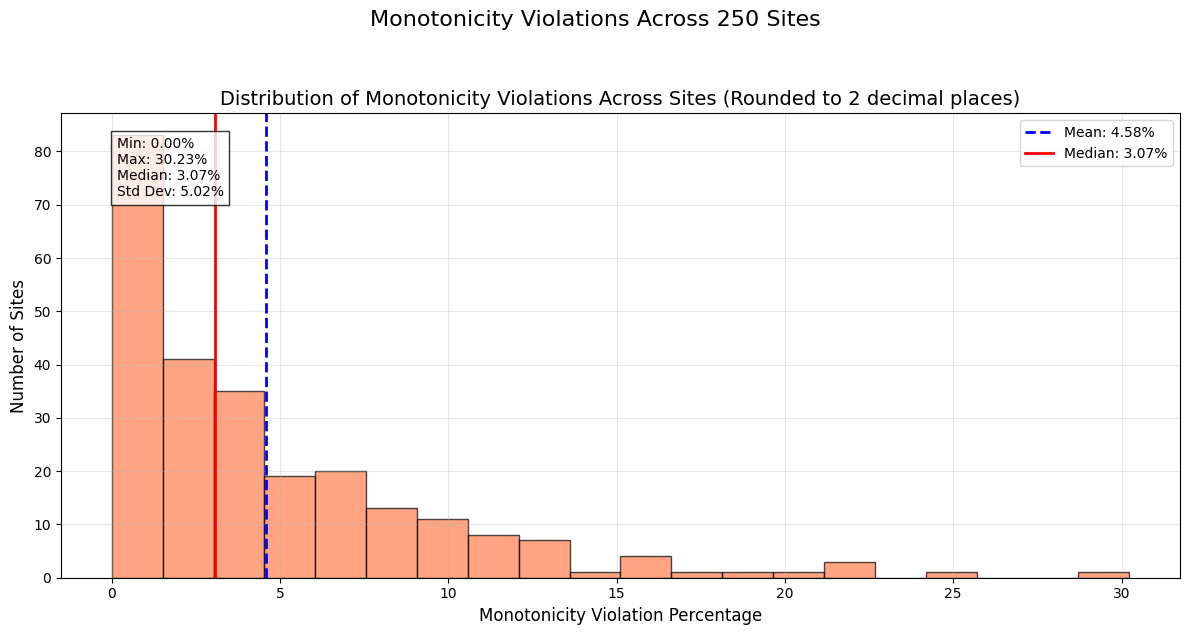

Total predictions: 180407
Total violations: 8244
Overall violation percentage: 4.57% (Rounded to 2 decimal places)


In [17]:
def compute_monotonicity_violations(pred_df, rounding=None):
    """
    Compute percentage of monotonicity violations by site_id.
    Predictions should follow: XC0 >= XC10 >= XC20 >= ... >= XC100
    
    Args:
        pred_df: DataFrame with predictions
        rounding: Number of decimal places to round predictions before checking monotonicity.
                  If None, no rounding is applied.
        
    Returns:
        DataFrame with site_id and percentage of violations
    """
    import pandas as pd
    import numpy as np
    
    # List of XC thresholds in order
    thresholds = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    pred_cols = [f'pred_XC{t}' for t in thresholds]
    
    # Results container
    results = []
    
    # For each site_id
    for site_id in pred_df['site_id'].unique():
        site_preds = pred_df[pred_df['site_id'] == site_id]
        
        # Count total rows for this site
        total_rows = len(site_preds)
        
        # Initialize violation counter
        violation_count = 0
        
        # For each row, check monotonicity
        for _, row in site_preds.iterrows():
            # Extract prediction values
            pred_values = [row[col] for col in pred_cols]
            
            # Apply rounding if specified
            if rounding is not None:
                pred_values = [round(val, rounding) for val in pred_values]
            
            # Check if monotonically decreasing
            is_monotonic = all(pred_values[i] >= pred_values[i+1] for i in range(len(pred_values)-1))
            
            if not is_monotonic:
                violation_count += 1
        
        # Calculate violation percentage
        violation_pct = (violation_count / total_rows) * 100 if total_rows > 0 else 0
        
        results.append({
            'site_id': site_id,
            'total_predictions': total_rows,
            'violations': violation_count,
            'violation_pct': violation_pct
        })
    
    return pd.DataFrame(results)

def plot_monotonicity_violations(violations_df, rounding=None):
    """
    Plot histogram of monotonicity violations percentage across sites.
    
    Args:
        violations_df: DataFrame with violation percentages by site_id
        rounding: The rounding parameter used (for title display)
    
    Returns:
        matplotlib figure
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Calculate overall statistics
    mean_violation_pct = violations_df['violation_pct'].mean()
    
    # Calculate median
    median_violation_pct = violations_df['violation_pct'].median()
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot histogram
    ax.hist(violations_df['violation_pct'], bins=20, alpha=0.7, 
            color='coral', edgecolor='black')
    
    # Add reference lines
    ax.axvline(x=mean_violation_pct, color='blue', linestyle='--', linewidth=2,
               label=f'Mean: {mean_violation_pct:.2f}%')
    ax.axvline(x=median_violation_pct, color='red', linestyle='-', linewidth=2,
               label=f'Median: {median_violation_pct:.2f}%')
    
    # Add labels and title
    ax.set_xlabel('Monotonicity Violation Percentage', fontsize=12)
    ax.set_ylabel('Number of Sites', fontsize=12)
    
    # Adjust title based on rounding parameter
    rounding_text = f" (Rounded to {rounding} decimal places)" if rounding is not None else ""
    ax.set_title(f'Distribution of Monotonicity Violations Across Sites{rounding_text}', fontsize=14)
    
    # Add legend
    ax.legend()
    
    # Add grid
    ax.grid(alpha=0.3)
    
    # Display statistics in a text box
    stats = (f"Min: {violations_df['violation_pct'].min():.2f}%\n"
             f"Max: {violations_df['violation_pct'].max():.2f}%\n"
             f"Median: {violations_df['violation_pct'].median():.2f}%\n"
             f"Std Dev: {violations_df['violation_pct'].std():.2f}%")
    
    ax.text(0.05, 0.95, stats, transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.8), verticalalignment='top')
    
    # Show sample count
    sample_count = len(violations_df)
    plt.suptitle(f'Monotonicity Violations Across {sample_count} Sites', 
                 fontsize=16, y=1.05)
    
    plt.tight_layout()
    plt.show()
    
    # Print overall statistics
    total_preds = violations_df['total_predictions'].sum()
    total_violations = violations_df['violations'].sum()
    overall_violation_pct = (total_violations / total_preds) * 100 if total_preds > 0 else 0
    
    print(f"Total predictions: {total_preds}")
    print(f"Total violations: {total_violations}")
    print(f"Overall violation percentage: {overall_violation_pct:.2f}%{rounding_text}")
    
    return fig


violations_df = compute_monotonicity_violations(pred_df, rounding=2)
plot_monotonicity_violations(violations_df, rounding=2);

In [18]:
violations_df.sort_values(by='violation_pct', ascending=False).head(50)


,site_id,total_predictions,violations,violation_pct
151,82,708,214,30.225989
245,160,710,180,25.352113
139,120,724,159,21.961326
148,153,710,153,21.549296
94,95,750,161,21.466667
244,133,731,146,19.972640
4,136,708,137,19.350282
191,83,673,121,17.979198
205,106,747,123,16.465863
218,221,727,115,15.818432


In [19]:
cross_layer_weights = model.cross_net.kernels[0].data.cpu().numpy()


In [20]:
col_names = gfs.fetch.get_col_order()

references = (
    (6, 3),
    (12, 0),
    (12, 3)
)
col_names_full = []
for run, delta in references:
    for col in col_names:
        col_names_full.append(f'{col}_{run+delta}')

In [21]:
weather_features = col_names_full
site_features = ['latitude', 'longitude', 'altitude']
date_features = ['weekend', 'year', 'day_of_year_sin', 'day_of_year_cos']


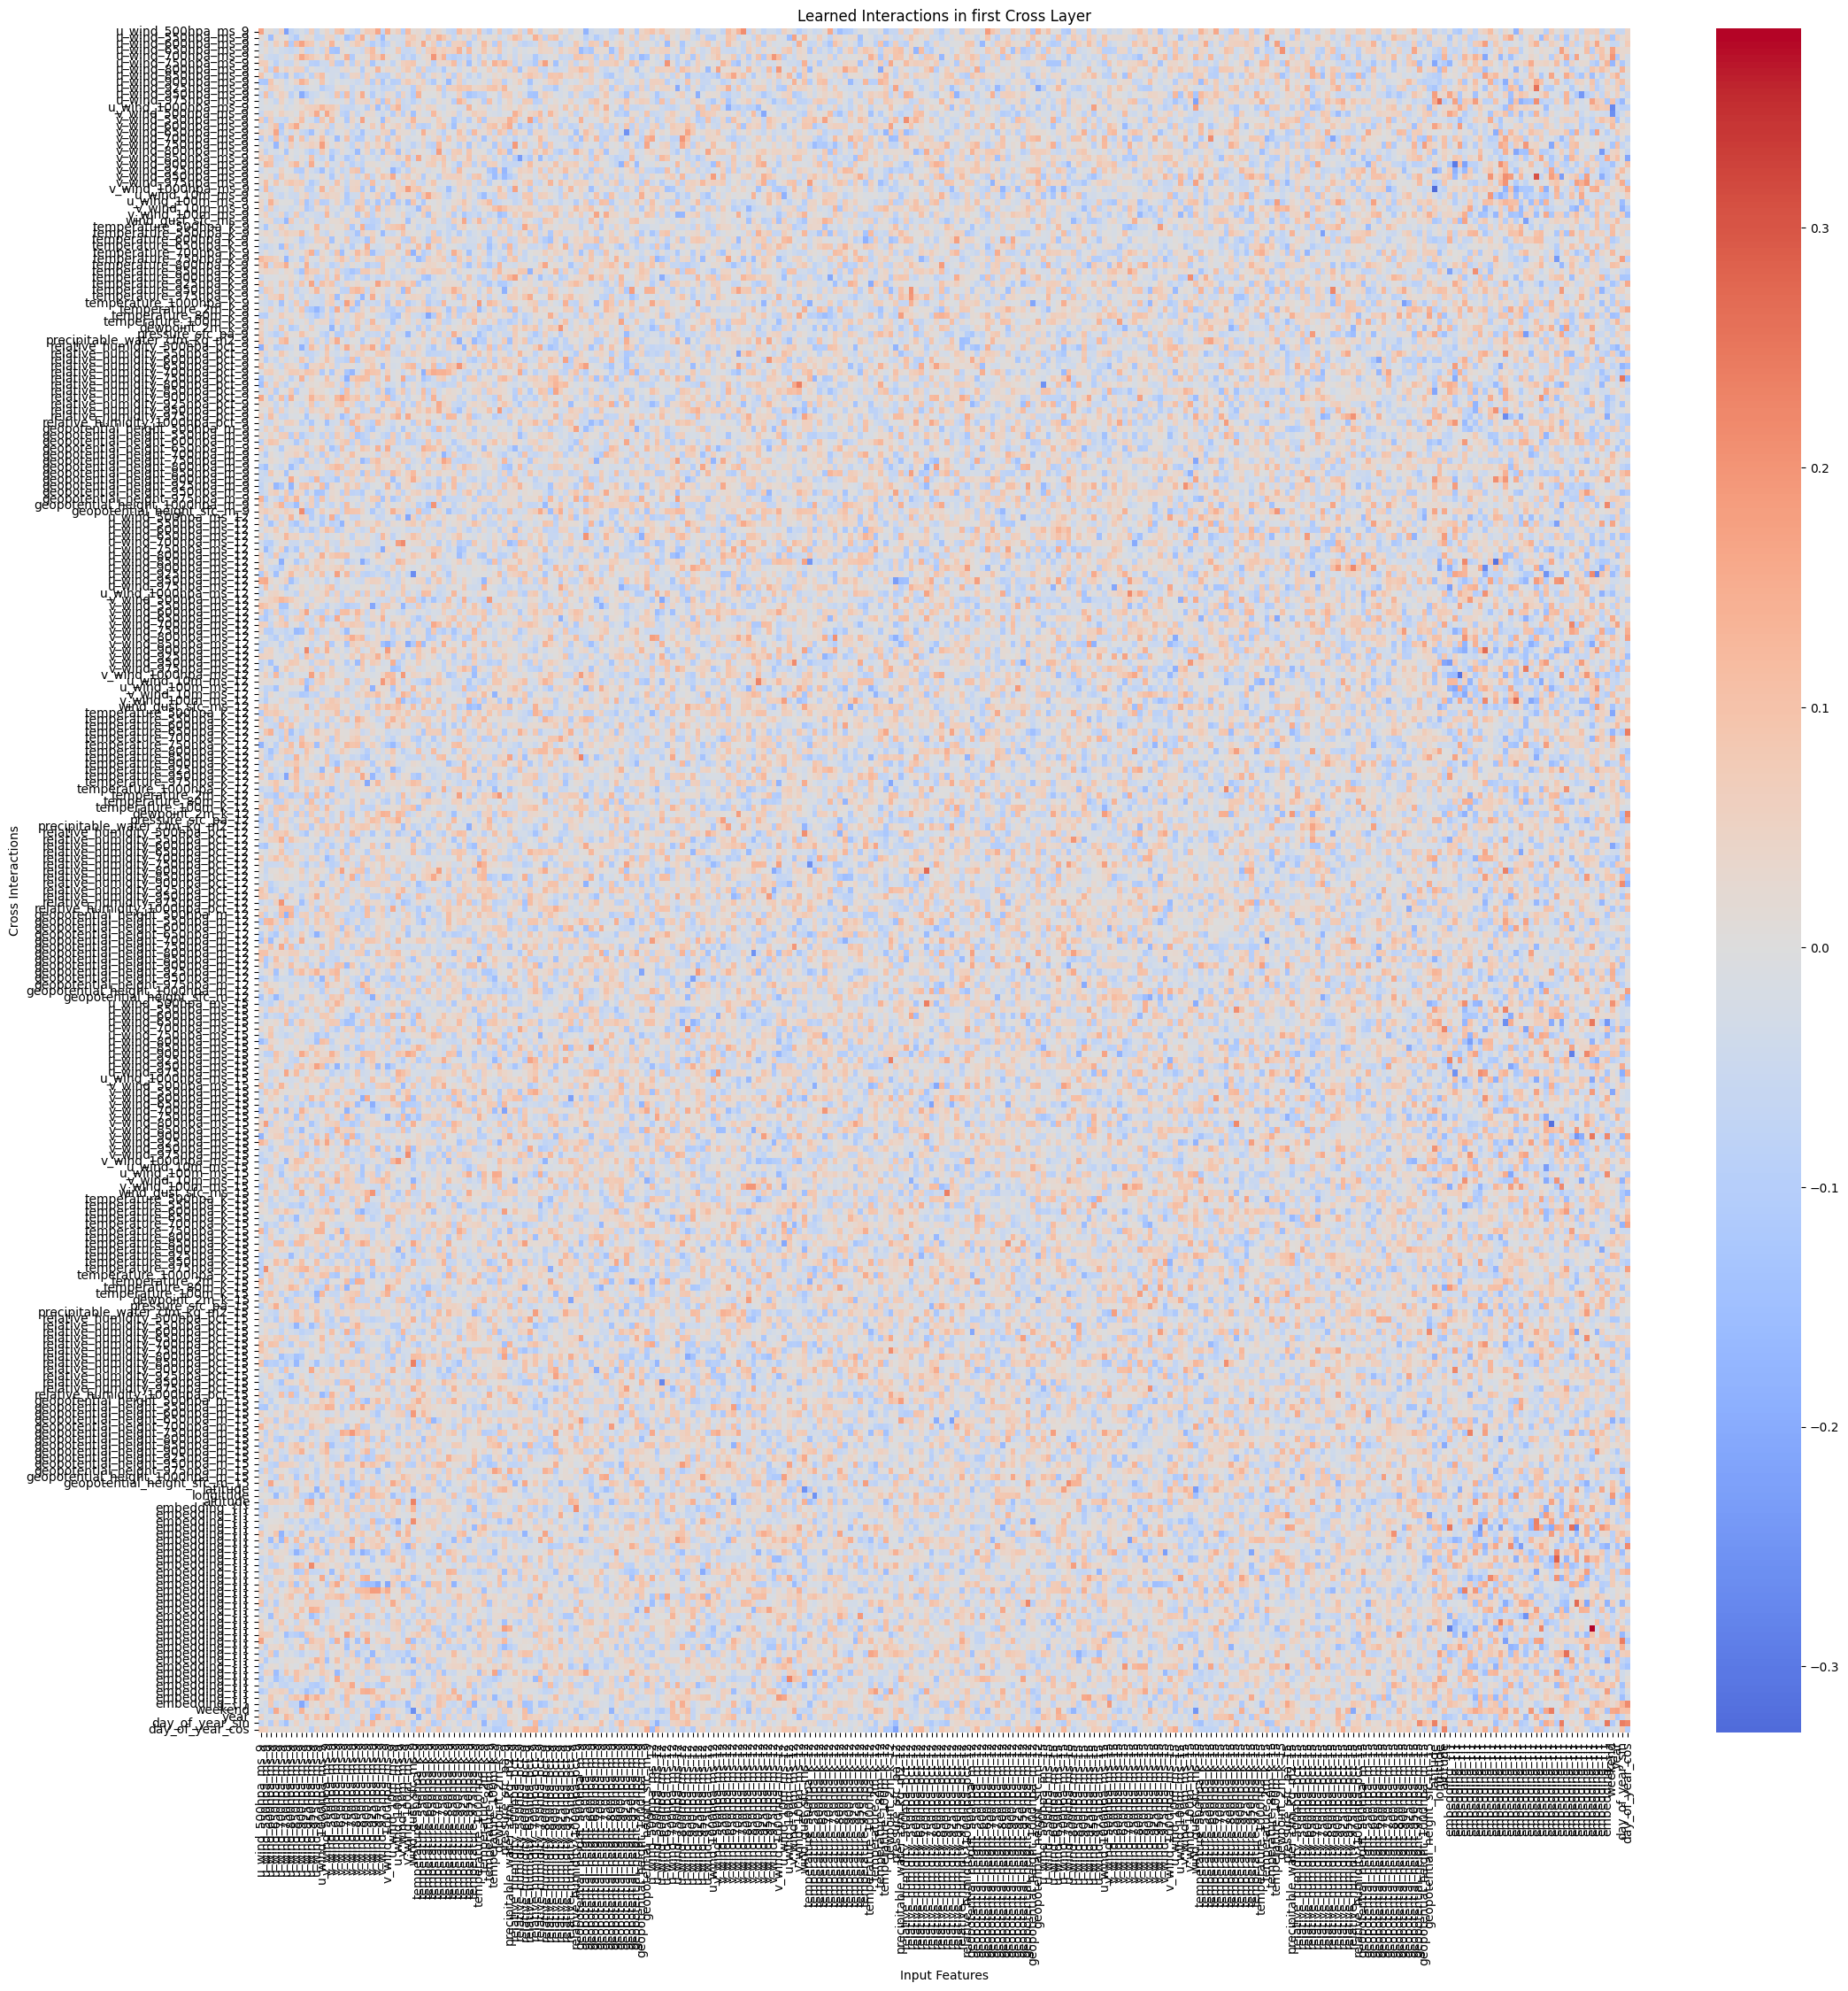

In [22]:
plt.figure(figsize=(25, 25))
sns.heatmap(cross_layer_weights, annot=False, cmap='coolwarm', center=0,
            xticklabels=weather_features + site_features + ['embedding_{i}' for i in range(32)] + date_features,
            yticklabels=weather_features + site_features + ['embedding_{i}' for i in range(32)] + date_features)

plt.title(f"Learned Interactions in first Cross Layer")
plt.xlabel("Input Features")
plt.ylabel("Cross Interactions")
plt.show()

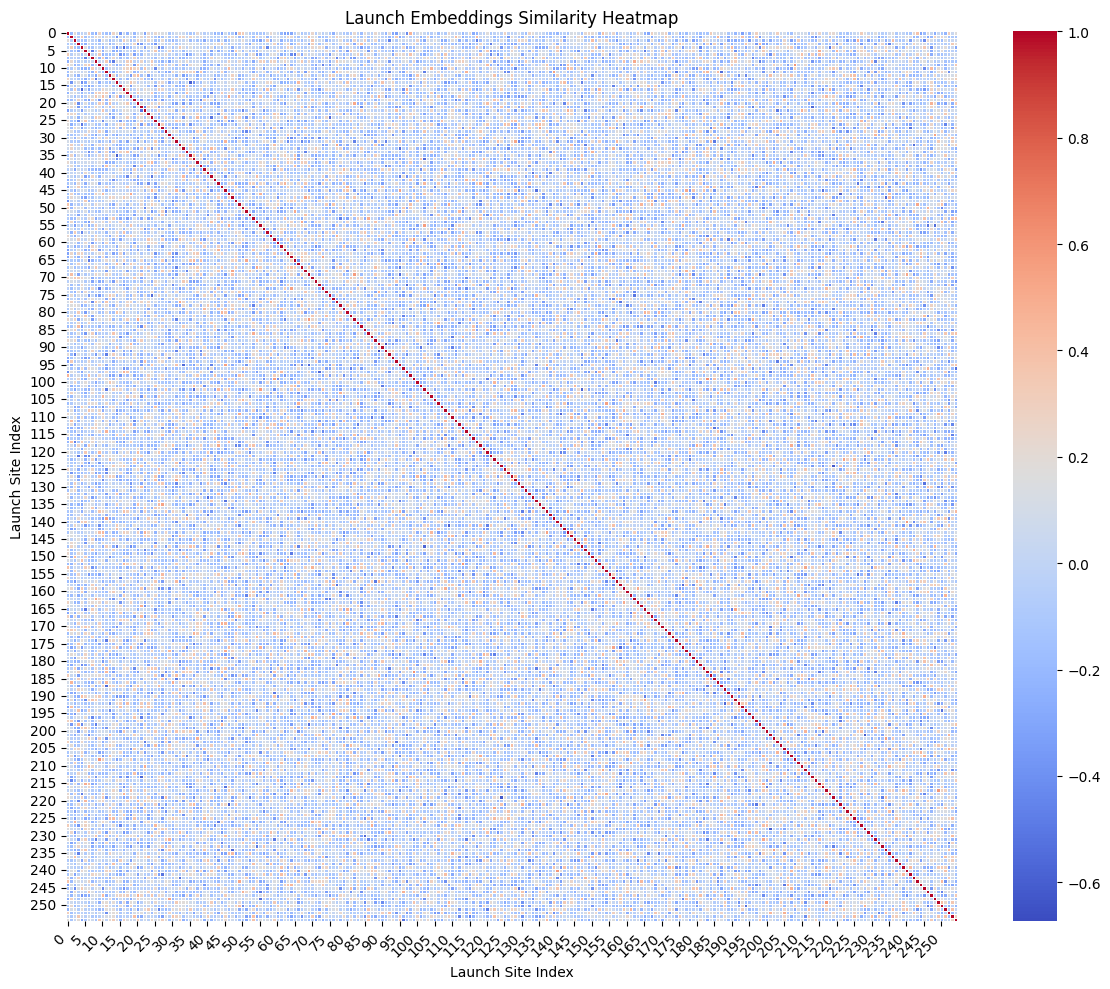

In [23]:
from sklearn.metrics.pairwise import cosine_similarity

# Function Definitions (from previous code blocks)
def extract_embeddings(model):
    embeddings = model.launch_embedding.weight.data.cpu().numpy()
    embeddings_df = pd.DataFrame(embeddings)
    embeddings_df.index.name = 'Launch'
    return embeddings_df

def compute_pairwise_similarities(embeddings_df):
    similarity_matrix = cosine_similarity(embeddings_df.values)
    similarity_df = pd.DataFrame(similarity_matrix)
    return similarity_df

def plot_similarity_heatmap(similarity_df, title='Launch Embeddings Similarity Heatmap'):
    plt.figure(figsize=(12, 10))
    sns.heatmap(similarity_df, annot=False, cmap='coolwarm', linewidths=0.5)
    plt.title(title)
    plt.xlabel('Launch Site Index')
    plt.ylabel('Launch Site Index') 
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Ensure the model is in evaluation mode
model.eval()

# Extract embeddings
embeddings_df = extract_embeddings(model)

# Compute pairwise similarities
similarity_df = compute_pairwise_similarities(embeddings_df)

# Plot the similarity heatmap
plot_similarity_heatmap(similarity_df)